In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd
import sys
from tensorflow.keras.utils import to_categorical  # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout 
from matplotlib import pyplot as plt # 학습 과정 그래프 
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # 데이터 분리

In [3]:
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.info() # dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [4]:
# '?'를 결측치(np.nan)로 대체
df = dataset.replace('?', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [5]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [6]:
# 결측치 처리 : 대체 or 제거
df.fillna(value=df.median(), inplace=True) # 결측치를 중위수로 대체
# df = df.dropna(how='any')  #결측치 제거
df.isna().sum() # 결측치가 없는지 확인

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [7]:
# Target변수의 분포(0:음성, 1:양성)
print(df['heartDisease'].value_counts()) 
# negative, positive = df['heartDisease'].value_counts()
# total = df.shape[0]
# print('음성 결과 :', negative/total)
# print('양성 결과 :', positive/total)
print(df['heartDisease'].value_counts(normalize=True))

0    164
1    139
Name: heartDisease, dtype: int64
0    0.541254
1    0.458746
Name: heartDisease, dtype: float64


In [8]:
# 입력변수와 타겟변수 분리
X = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
X.shape, y.shape

((303, 13), (303, 1))

In [9]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[:2]

array([[0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
        1.        , 1.        , 0.60305344, 0.        , 0.37096774,
        1.        , 0.        , 0.75      ],
       [0.79166667, 1.        , 1.        , 0.62264151, 0.3652968 ,
        0.        , 0.        , 0.28244275, 1.        , 0.24193548,
        0.5       , 1.        , 0.        ]])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                   y,
                                                   test_size=0.3, # 테스트셋비율
                                                   random_state=7,
                                                   stratify=y # 층화추출
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((212, 13), (91, 13), (212, 1), (91, 1))

In [11]:
# 음성|양성 비율
print(pd.DataFrame(y).value_counts(normalize=True)) # 전체 데이터
print(pd.DataFrame(y_train).value_counts(normalize=True)) # y_train
print(pd.DataFrame(y_test).value_counts(normalize=True)) # y_test

0    0.541254
1    0.458746
dtype: float64
0    0.542453
1    0.457547
dtype: float64
0    0.538462
1    0.461538
dtype: float64


In [13]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=150, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                896       
                                                                 
 dense_4 (Dense)             (None, 150)               9750      
                                                                 
 dense_5 (Dense)             (None, 100)               15100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,847
Trainable params: 30,847
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras import metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy',
            metrics.Recall(),
            metrics.Precision()]
)


In [19]:
hist = model.fit(X_train, y_train,           # 훈련 데이터
                    validation_split=0.2, # 검증 데이터
                    epochs=150,                         # 반복 횟수
                    batch_size=32,                     # 배치 크기
                    verbose=1)                         # 출력 모드


Epoch 1/150
6/6 [==============================] - 0s 14ms/step - loss: 0.0016 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7295 - val_binary_accuracy: 0.7907 - val_recall: 0.7619 - val_precision: 0.8000
Epoch 2/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7346 - val_binary_accuracy: 0.7907 - val_recall: 0.7619 - val_precision: 0.8000
Epoch 3/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0014 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7289 - val_binary_accuracy: 0.7907 - val_recall: 0.7619 - val_precision: 0.8000
Epoch 4/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.7249 - val_binary_accuracy: 0.7907 - val_recall: 0.7619 - val_precision: 0.8000
Epoch 5/150
6/6 [==============================] - 0s 9ms/s

Epoch 36/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0740 - binary_accuracy: 0.9704 - recall: 0.9737 - precision: 0.9610 - val_loss: 0.9114 - val_binary_accuracy: 0.8372 - val_recall: 0.9048 - val_precision: 0.7917
Epoch 37/150
6/6 [==============================] - 0s 9ms/step - loss: 0.0608 - binary_accuracy: 0.9704 - recall: 1.0000 - precision: 0.9383 - val_loss: 0.8520 - val_binary_accuracy: 0.8372 - val_recall: 0.8571 - val_precision: 0.8182
Epoch 38/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0317 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.9261 - val_binary_accuracy: 0.7907 - val_recall: 0.7619 - val_precision: 0.8000
Epoch 39/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0223 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.9758 - val_binary_accuracy: 0.8372 - val_recall: 0.8571 - val_precision: 0.8182
Epoch 40/150
6/6 [==============================] - 0s 8

Epoch 71/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.5275 - val_binary_accuracy: 0.8372 - val_recall: 0.8571 - val_precision: 0.8182
Epoch 72/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.5421 - val_binary_accuracy: 0.8372 - val_recall: 0.8571 - val_precision: 0.8182
Epoch 73/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.5433 - val_binary_accuracy: 0.8372 - val_recall: 0.8571 - val_precision: 0.8182
Epoch 74/150
6/6 [==============================] - 0s 8ms/step - loss: 0.0010 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.5424 - val_binary_accuracy: 0.8140 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 75/150
6/6 [==============================] - 0s 8

6/6 [==============================] - 0s 8ms/step - loss: 1.7174e-04 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9256 - val_binary_accuracy: 0.8140 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 140/150
6/6 [==============================] - 0s 8ms/step - loss: 1.6786e-04 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9330 - val_binary_accuracy: 0.8140 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 141/150
6/6 [==============================] - 0s 8ms/step - loss: 1.6338e-04 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9389 - val_binary_accuracy: 0.8140 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 142/150
6/6 [==============================] - 0s 8ms/step - loss: 1.6108e-04 - binary_accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.9451 - val_binary_accuracy: 0.8140 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 143/150
6/6 [==============================]

In [20]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])

KeyError: 'accuracy'

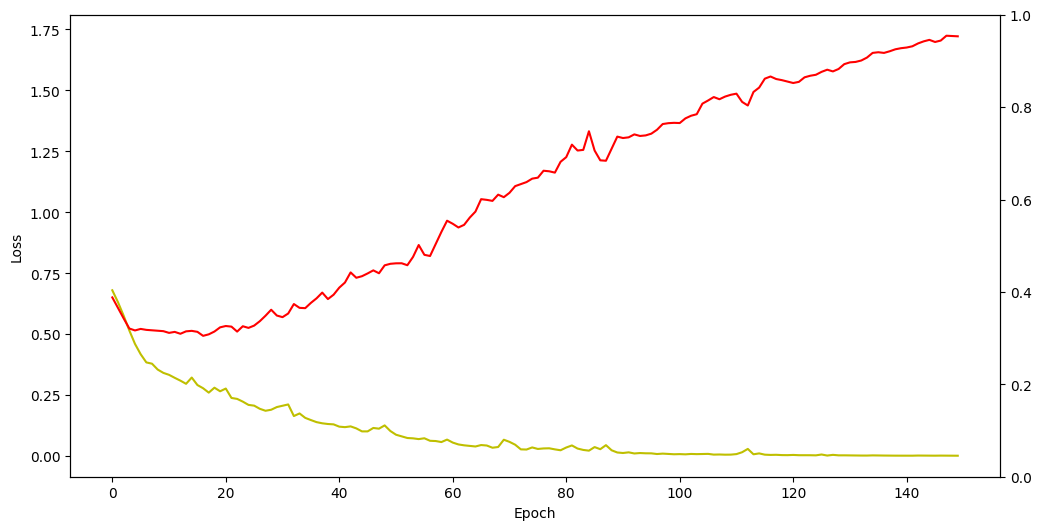

In [29]:
import matplotlib.pyplot as plt

# 하나의 Figure + 2개의 y축 (왼쪽: 손실, 오른쪽: 정확도)
fig, loss_ax = plt.subplots(figsize=(12, 6))

# 왼쪽 y축: Loss
loss_ax.plot(history.history['loss'], 'y', label='Train Loss')
loss_ax.plot(history.history['val_loss'], 'r', label='Val Loss')
loss_ax.set_xlabel('Epoch')
loss_ax.set_ylabel('Loss')


# 오른쪽 y축: Accuracy
acc_ax = loss_ax.twinx()
acc_ax.plot(history.history['accuracy'], 'g', label='Train Acc')
acc_ax.plot(history.history['val_accuracy'], 'b', label='Val Acc')
acc_ax.set_ylabel('Accuracy')


plt.show()


In [23]:
# 교차표
y_test.reshape(-1)

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0], dtype=int64)

In [25]:
y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
pd.crosstab(y_test.reshape(-1), y_hat, 
           rownames=['실제값'], colnames=['예측값'])

3/3 [==============================] - 0s 2ms/step


예측값,0,1
실제값,,
0,41,8
1,7,35


In [26]:
model.save('model/practice2.h5')
save_model(model, 'model/practice2.h5')

In [28]:
model2 = load_model('model/practice2.h5')
model2


## 분류분석


In [30]:
Y_train = to_categorical(y_train)
Y_test  = to_categorical(y_test)
Y_train.shape, Y_test.shape

((212, 2), (91, 2))

In [31]:
model = Sequential()
# model.add(Input(shape=(13,)))
model.add(Dense(units=32, 
                input_dim=13,
                activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(units=1,  activation='sigmoid'))
model.add(Dense(units=2,  activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 2)                

In [32]:
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam',
             metrics=['accuracy', # 정확도
                      metrics.Recall(), # 재현율(실제값 중심)
                      metrics.Precision()]) # 정밀도(예측값 중심)

In [33]:
%%time
hist = model.fit(X_train, Y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

CPU times: total: 10.7 s
Wall time: 8.22 s


In [34]:

hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'precision_1', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision_1'])

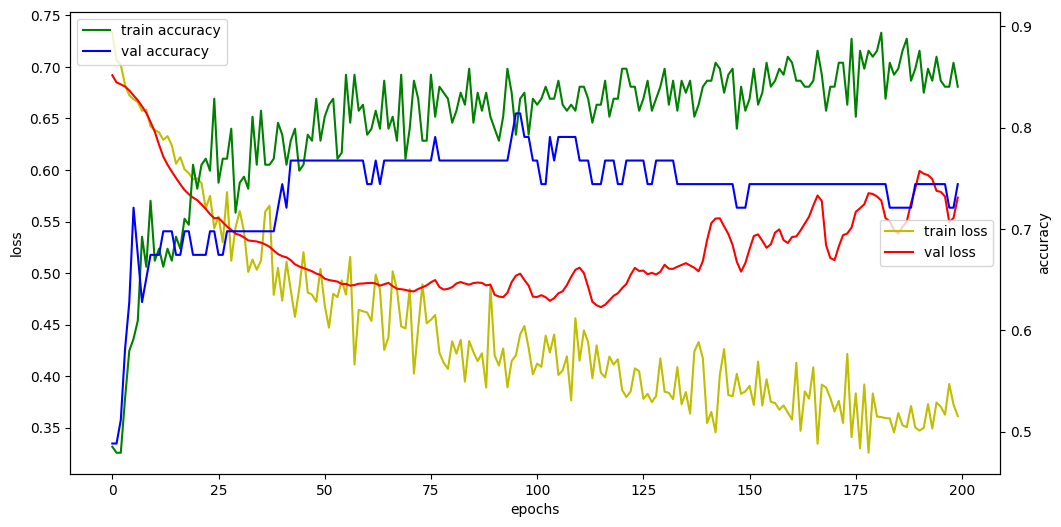

In [35]:
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()